In [2]:
import sys 
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import numpy as np
plt.style.use('ggplot')
sys.path.append('..')

from utils import dataloader

In [3]:
df = dataloader.load_data()

In [4]:
G, adj, edge_index, edge_weight  = dataloader.get_graph(df, adjecency_threshold_km=1.5)
edge_index, edge_weight, G.nodes

(tensor([[0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 5, 6, 6, 7, 7, 7, 7],
         [0, 2, 3, 7, 1, 6, 0, 2, 3, 7, 0, 2, 3, 7, 4, 5, 1, 6, 0, 2, 3, 7]]),
 tensor([1.0000, 0.7505, 0.6965, 0.6641, 1.0000, 0.7424, 0.7505, 1.0000, 0.7615,
         0.6265, 0.6965, 0.7615, 1.0000, 0.4966, 1.0000, 1.0000, 0.7424, 1.0000,
         0.6641, 0.6265, 0.4966, 1.0000]),
 NodeView(('BRYANT', 'CAMBRIDGE', 'HAMILTON', 'HIGH', 'MPL', 'RINCONADA', 'TED', 'WEBSTER')))

TypeError: unsupported operand type(s) for *: 'dict' and 'float'

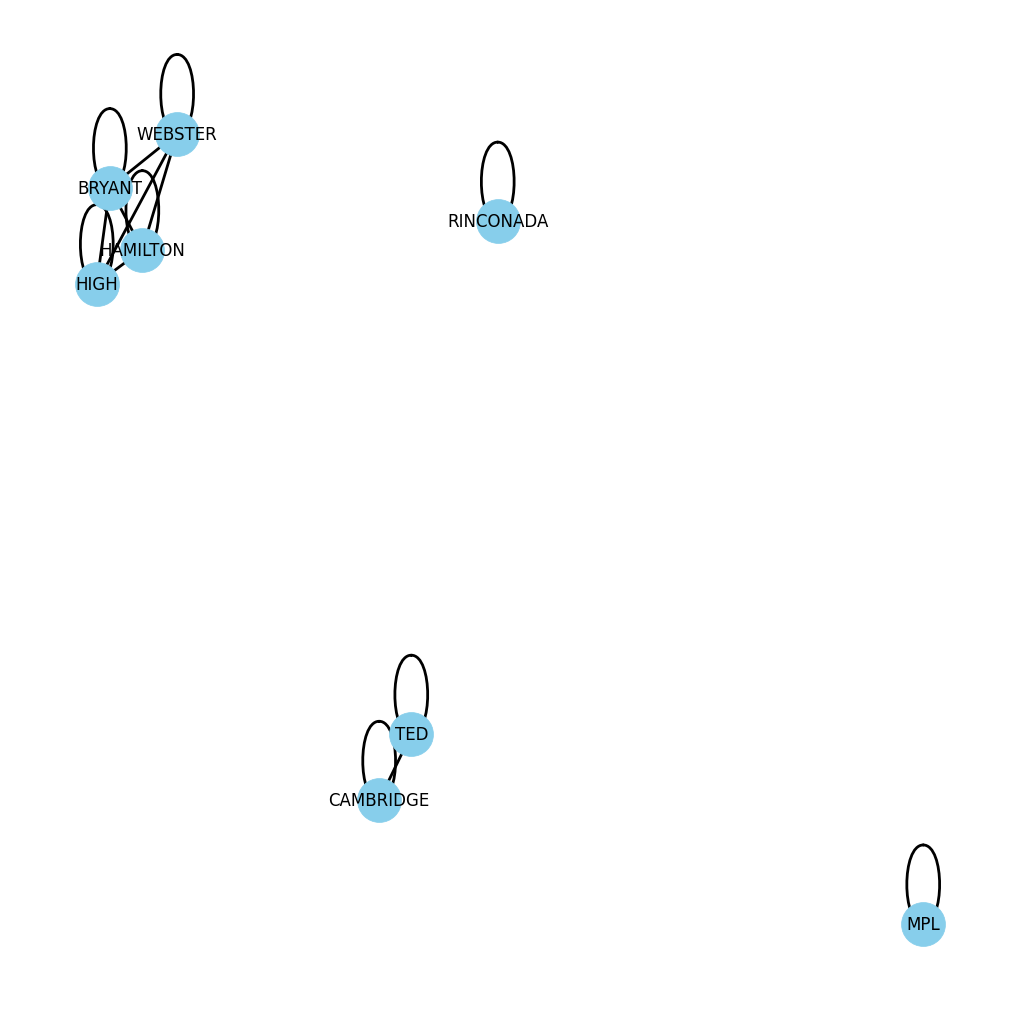

In [6]:
# plot graph
# Plot graph with edge weights
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', edge_cmap=plt.cm.Blues, width=2)
edge_labels = nx.get_edge_attributes(G,'weight')
# round to 2 decimals
edge_labels = dict([((u,v,), np.round(d, 2)) for u, v, d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [14]:
df_sess = pd.read_csv('../data/charging_session_count_30.csv', parse_dates=['Period'])
df_sess = df_sess[df_sess['Period'] > '2019-01-01'].reset_index(drop=True)
print(df_sess.Period.min(), df_sess.Period.max())
df_sess.head()

2019-01-01 00:30:00 2020-07-05 14:30:00


,Period,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA,TED,WEBSTER
0,2019-01-01 00:30:00,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
1,2019-01-01 01:00:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01 01:30:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-01 02:00:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01 02:30:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [15]:
LAGS = 30
feats, targets = dataloader.get_targets_and_features_tgcn(df_sess, lags=LAGS, add_month=True, add_day_of_week=True, add_hour=True)
time_length, nodes, feature_num, lag = feats.shape
print(f"Time length: {time_length}, Nodes: {nodes}, Features: {feature_num}, Lag: {lag}")
feats.shape

Time length: 26447, Nodes: 8, Features: 8, Lag: 30


(26447, 8, 8, 30)

In [16]:
if False:
    np.save('../data/feats.npy', feats)
    np.save('../data/targets.npy', targets)
    np.save('../data/edge_index.npy', data.edge_index)
    np.save('../data/edge_weight.npy', data.edge_weight.float())


In [17]:
test_start = "2020-03-01"
start_index = df_sess[df_sess.Period >= test_start].index[0]
X_train, y_train = feats[:start_index], targets[:start_index]
X_test, y_test = feats[start_index:], targets[start_index:]
print(X_train.shape, X_test.shape)
print(f"{X_test.shape[0]/df_sess.shape[0]*100:0.2f}% of data is test data")

(20399, 8, 8, 30) (6048, 8, 8, 30)
22.84% of data is test data


In [19]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

train_x_tensor = torch.from_numpy(X_train).type(torch.FloatTensor).to(DEVICE)  
train_target_tensor = torch.from_numpy(y_train).type(torch.FloatTensor).to(DEVICE)

train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

In [20]:
X_test_tensor = torch.from_numpy(X_test).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
y_test_tensor = torch.from_numpy(y_test).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

In [24]:
model = TemporalGCN(node_features=feature_num, hidden_dim=128, time_steps=lag)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.PoissonNLLLoss(log_input=False)
mean_absolute_error = torch.nn.L1Loss()
model = model.to(DEVICE)
model.train()


epoch_loss, epoch_mae = [], []
for epoch in range(20):
    losses_nll, losses_mae = [], [] 
    for x, y in train_loader:
        optimizer.zero_grad()
        y_hat, _ = model(x, edge_index, edge_weight.float())
        y_hat = y_hat.view(batch_size, nodes)

        loss = loss_func(y_hat, y)
        mae  = mean_absolute_error(y_hat, y)
        losses_nll.append(loss.item())
        losses_mae.append(mae.item())
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, cost {np.mean(losses_nll)}, mean_absolute_error: {np.mean(losses_mae)}")
    epoch_loss.append(np.mean(losses_nll))
    epoch_mae.append(np.mean(losses_mae))

Epoch 0, cost -0.17933644155870826, mean_absolute_error: 0.8655910624813996


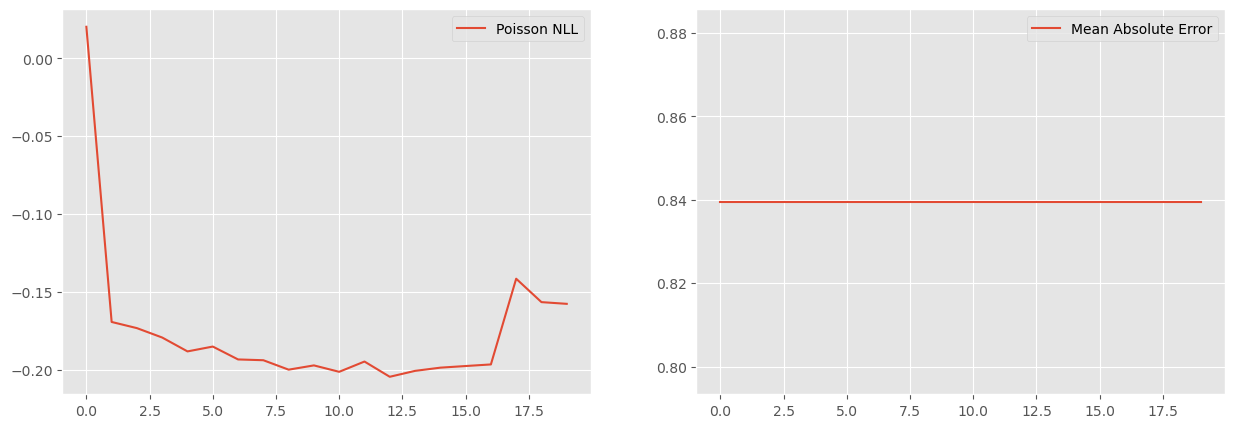

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(epoch_loss, label='Poisson NLL')
axs[1].plot(epoch_mae, label='Mean Absolute Error')
axs[1].legend()
axs[0].legend()
plt.show()

In [ ]:
preds, true = [], []
model.load_state_dict(torch.load('model.pt', map_location=DEVICE))
# model.eval()
for x, y in test_loader:
    y_hat, hidden_state = model(x, edge_index, edge_weight.float())
    preds.append(y_hat.detach().numpy())
    true.append(y.detach().numpy())


In [ ]:
column_names = df_sess.columns.difference(['Period', 'hour'])
print(len(column_names))
np.array(preds).reshape(-1, nodes).shape


8


(21152, 8)

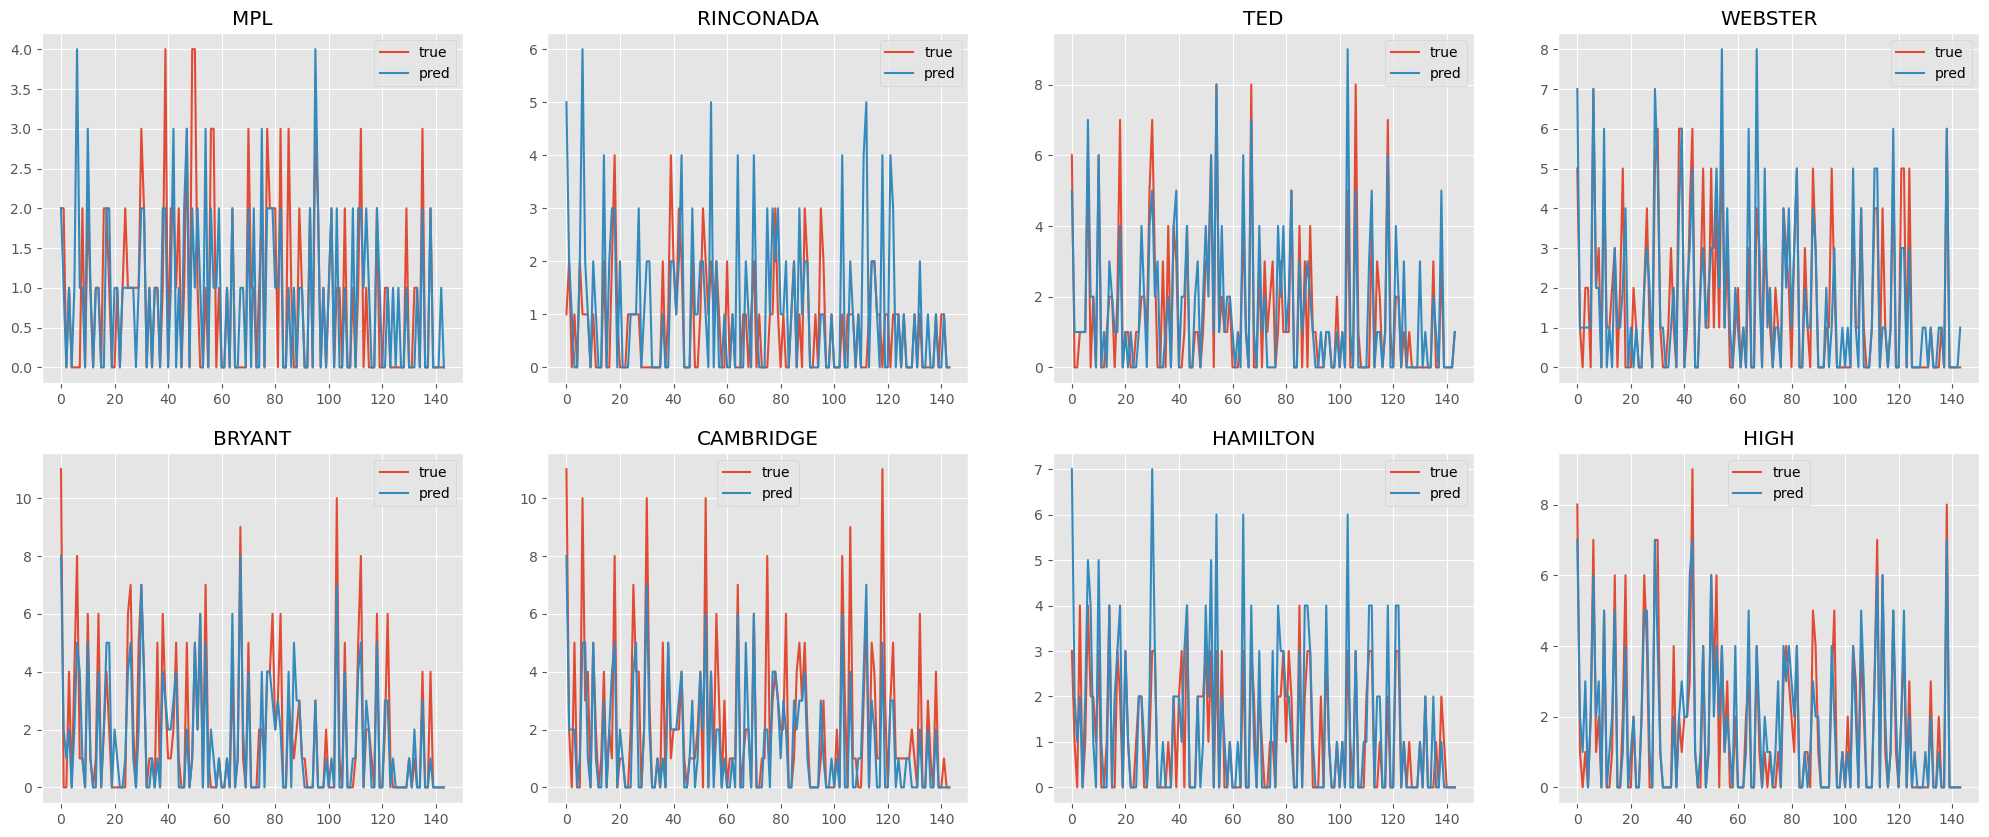

In [ ]:
fig, axs = plt.subplots(2,4, figsize=(25,10))
labels = np.array(true).reshape(-1, nodes)
predictions = np.array(preds).reshape(-1, nodes).round()
_x = np.arange(true[:,i].shape[0])

many = 2*24*3

predictions = preds[-many:]
labels = true[-many:]
for i in range(len(column_names)):
    if i >= 4:
        axs[0, i-4].set_title(column_names[i])
        axs[0,i-4].plot(labels[:,i], label='true')
        axs[0,i-4].plot(predictions[:,i], label='pred')
        axs[0,i-4].legend()
    else:
        axs[1,i].set_title(column_names[i])
        axs[1, i].plot(labels[:,i], label='true')
        axs[1, i].plot(predictions[:,i], label='pred')
        axs[1, i].legend()
plt.show()

In [ ]:
preds[-1:].shape

(1, 8)